In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 357.42it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 5028.66it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 4453.67it/s]


In [2]:
trained = np.concatenate((predict_label_diff_indicates, high_distance_indicates),axis=0)

In [ ]:
new_Rep = gen.generate_representation_by_cka( 500, np.concatenate((predict_label_diff_indicates, high_distance_indicates),axis=0))

In [13]:
sys.path.append('..')
from CKA_utils.CKA import CKA, CudaCKA
ind = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)
np_cka = CKA()
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(ref_train_data[absolute_alignment_indicates],tar_train_data[absolute_alignment_indicates]))
print('CKA between diff+same subset is:',np_cka.kernel_CKA(ref_train_data[ind],tar_train_data[ind]))
print('CKA between adjusted vs tar diff+same subset is:',np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates], new_Rep),axis=0),tar_train_data[ind]))
print('CKA between adjusted vs ref diff+same subset is:',np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates], new_Rep),axis=0),ref_train_data[ind]))

print('CKA between init ref vs tar diff subset is:',np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates],tar_train_data[predict_label_diff_indicates]))
print('CKA between adjusted vs tar diff subset is:',np_cka.kernel_CKA(new_Rep,tar_train_data[predict_label_diff_indicates]))
print('CKA between adjusted vs ref diff subset is:',np_cka.kernel_CKA(new_Rep,ref_train_data[predict_label_diff_indicates]))


In [40]:
representation = ref_provider.train_representation(200)
k = 0
inidcates = trained
for i in range(len(inidcates)):
    index = inidcates[i]
    representation[index] = new_Rep[k]
    k = k + 1

In [8]:
print('reference predict res: ', ref_prediction_res[predict_label_diff_indicates])
print('adjusetd ref  predict res: ', ref_provider.get_pred(200, new_Rep).argmax(axis=1))
print('adjusetd ref  predict res: ', tar_provider.get_pred(200, new_Rep).argmax(axis=1))
print('target        predict res: ', tar_prediction_res[predict_label_diff_indicates])

reference predict res:  [7 1 5 5 2 5 0 3 5 5 4 7 0 5]


100%|██████████| 1/1 [00:00<00:00, 2087.76it/s]


adjusetd ref  predict res:  [7 6 4 3 5 0 0 3 3 7 4 7 0 5]


100%|██████████| 1/1 [00:00<00:00, 1943.61it/s]

adjusetd ref  predict res:  [7 6 4 3 4 3 3 3 3 7 3 5 3 3]
target        predict res:  [5 6 4 3 4 3 3 5 3 7 3 5 1 3]


In [2]:
from alignment.TrainingSnapshotAlignmentCKA import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )

In [3]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

R = alignment.align_embeddings(Y,X,15000, 100)

iteration 0, loss1 87740376.0 loss2 {tensor(0.6504, grad_fn=<AddBackward0>)}
iteration 99, loss1 13228.7744140625 loss2 {tensor(0.6460, grad_fn=<AddBackward0>)}
iteration 198, loss1 3076.34912109375 loss2 {tensor(0.7416, grad_fn=<AddBackward0>)}
iteration 297, loss1 1362.8736572265625 loss2 {tensor(0.6861, grad_fn=<AddBackward0>)}
iteration 396, loss1 797.417724609375 loss2 {tensor(0.6016, grad_fn=<AddBackward0>)}
iteration 495, loss1 539.3733520507812 loss2 {tensor(0.5132, grad_fn=<AddBackward0>)}
iteration 594, loss1 398.797607421875 loss2 {tensor(0.4435, grad_fn=<AddBackward0>)}
iteration 693, loss1 315.06640625 loss2 {tensor(0.4008, grad_fn=<AddBackward0>)}
iteration 792, loss1 262.25250244140625 loss2 {tensor(0.3664, grad_fn=<AddBackward0>)}
iteration 891, loss1 226.34890747070312 loss2 {tensor(0.3421, grad_fn=<AddBackward0>)}
iteration 990, loss1 201.1293487548828 loss2 {tensor(0.3179, grad_fn=<AddBackward0>)}
iteration 1089, loss1 181.95472717285156 loss2 {tensor(0.2983, grad_fn

In [3]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]
from alignment.align_m import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )
R_n = alignment_n.align_embeddings(Y,X,15000,10,1e-3)

iteration 0, loss1 87740376.0 loss2 {tensor(0.6505, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8226, requires_grad=True)}
iteration 99, loss1 13227.0986328125 loss2 {tensor(0.6467, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7057, requires_grad=True)}
iteration 198, loss1 3078.332275390625 loss2 {tensor(0.7505, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6368, requires_grad=True)}
iteration 297, loss1 1366.5640869140625 loss2 {tensor(0.7162, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6160, requires_grad=True)}
iteration 396, loss1 802.3952026367188 loss2 {tensor(0.6579, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5925, requires_grad=True)}
iteration 495, loss1 545.2189331054688 loss2 {tensor(0.5946, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5632, requires_grad=True)}
iteration 594, loss1 404.9375305175781 loss2 {tensor(0.5396, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5217, requires_grad=True)}
iteration 693, loss1 320.9817810058594 loss2 {tensor(0.499

In [5]:
##### use the target * R to inverse project embedding and then use target predction to get color
from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')

In [14]:
from AlignVis.alignment_metrix_generator import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector,visualizer=vis )
X = ref_train_data
Y = tar_train_data
S = alignment.align_embeddings_S(X,Y,R_n.detach().numpy(), 5000,100,1e-8,0.005,0.005,20000)

len of align: 122
iteration 0, loss1 233780.1875 loss2 {tensor(0.9226, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8795, requires_grad=True)}
iteration 99, loss1 209709.546875 loss2 {tensor(0.9225, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 198, loss1 188117.40625 loss2 {tensor(0.9224, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 297, loss1 168748.53125 loss2 {tensor(0.9225, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 396, loss1 151373.953125 loss2 {tensor(0.9225, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 495, loss1 135788.359375 loss2 {tensor(0.9225, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 594, loss1 121807.546875 loss2 {tensor(0.9225, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8787, requires_grad=True)}
iteration 693, loss1 109266.28125 loss2 {tensor(0.9225, grad_fn=<

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_provider.train_representation(200),tr), projector, 200,[absolute_alignment_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [14]:
sys.path.append('..')
from CKA_utils.CKA import CKA, CudaCKA
ind = np.concatenate((absolute_alignment_indicates,predict_label_diff_indicates, high_distance_indicates),axis=0)
np_cka = CKA()
print('CKA between adjusted vs tar diff subset is:',np_cka.kernel_CKA(ref_train_data[absolute_alignment_indicates],tar_train_data[absolute_alignment_indicates]))

CKA between adjusted vs tar diff subset is: 0.9399421948154587


In [18]:
# print('CKA between adjusted vs tar diff subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[absolute_alignment_indicates],R.detach().numpy()),tar_train_data[absolute_alignment_indicates]))
print('CKA between adjusted vs tar diff subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[absolute_alignment_indicates],R_n.detach().numpy()),tar_train_data[absolute_alignment_indicates]))

CKA between adjusted vs tar diff subset is: 0.9470812240794262


In [17]:
import os
import json
with open(os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_experiments/droupoutContrast","clean_resnet18_with_dropout_R.json"), 'r') as file_obj:
   R = json.load(file_obj)

In [16]:
##### use the target * R to inverse project embedding and then use target predction to get color
from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
embedding = projector.batch_project(REF_EPOCH, np.dot(tar_train_data,R.detach().numpy()))
I = np.eye(512)

# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')

indices, grid = alignment2.get_grid_align_indicates(embedding,vis,TAR_EPOCH, 0.02,0.02)

# # Get the matching elements from both arrays
# matching_embedding = embedding[indices[0], :]
# matching_grid = grid[indices[1], :]

grid_samples = projector.batch_inverse(TAR_EPOCH, grid)
np_grid_samples = np.asarray(grid_samples)

Y_ = tar_train_data[indices[0]]
X_ = np_grid_samples[indices[1]]


NameError: name 'R' is not defined

In [11]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )
S = alignment.align_embeddings(X_,Y_,18000)

iteration 0, loss 23612724.110640828
iteration 1000, loss 676.8392049886193
iteration 2000, loss 510.84890105975745
iteration 3000, loss 421.3032736903005
iteration 4000, loss 363.4664565376601
iteration 5000, loss 322.8737127248567
iteration 6000, loss 292.807327297923
iteration 7000, loss 269.6332283081582
iteration 8000, loss 251.20950876559624
iteration 9000, loss 236.19531653910565
iteration 10000, loss 223.71051040342667
iteration 11000, loss 213.15438865236743
iteration 12000, loss 204.1033357171603
iteration 13000, loss 196.25019052042074
iteration 14000, loss 189.3668341728306
iteration 15000, loss 183.28028062833152
iteration 16000, loss 177.85692586722234
iteration 17000, loss 172.99189352729329


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9421.17it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

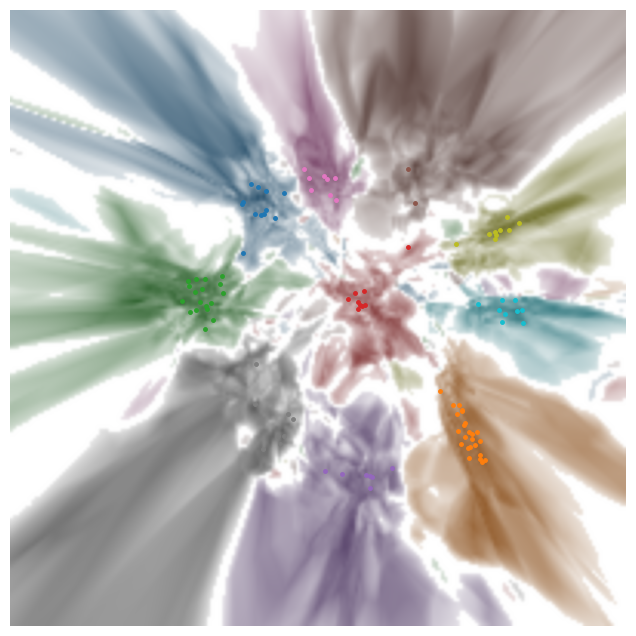

In [20]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[absolute_alignment_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [10]:
from alignment.TrainingSnapshotAlignmentCKA import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )
# alignment = 

In [29]:
ref_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(tar_provider.train_representation(TAR_EPOCH),I), ref_projector, 200,[0,1],'tab10')
embedding_in_ref = ref_projector.batch_project(200, np.dot(ref_train_data, R_n.detach().numpy()))
indices, grid = alignment.get_grid_align_indicates(embedding_in_ref,vis,TAR_EPOCH, 0.02,0.02)

len of align: 2774


In [30]:
tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
np_grid_samples = np.asarray(grid_samples)

In [68]:

embedding = tar_projector.batch_project(200, tar_train_data)

In [25]:
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')

indices, grid = alignment.get_grid_align_indicates(embedding_in_ref,vis,TAR_EPOCH, 0.02,0.02)

# # Get the matching elements from both arrays
# matching_embedding = embedding[indices[0], :]
# matching_grid = grid[indices[1], :]

grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
np_grid_samples = np.asarray(grid_samples)


len of align: 10119


In [37]:
projector_ref = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

In [38]:
ref_grid = projector_ref.batch_inverse(TAR_EPOCH, grid)
# np_ref_grid_samples = np.asarray(ref_grid)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5101.39it/s]


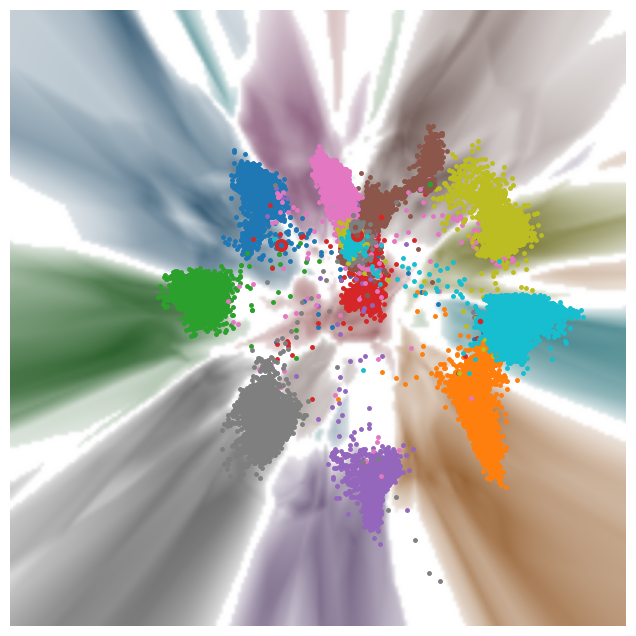

In [31]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from alignment.teet import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data,R_n.detach().numpy()), projector, 200,[],np.dot(np_grid_samples,R_n.detach().numpy()),'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [32]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S.detach().numpy(),I, np.dot(ref_train_data,I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

NameError: name 'S' is not defined

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 1787.93it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

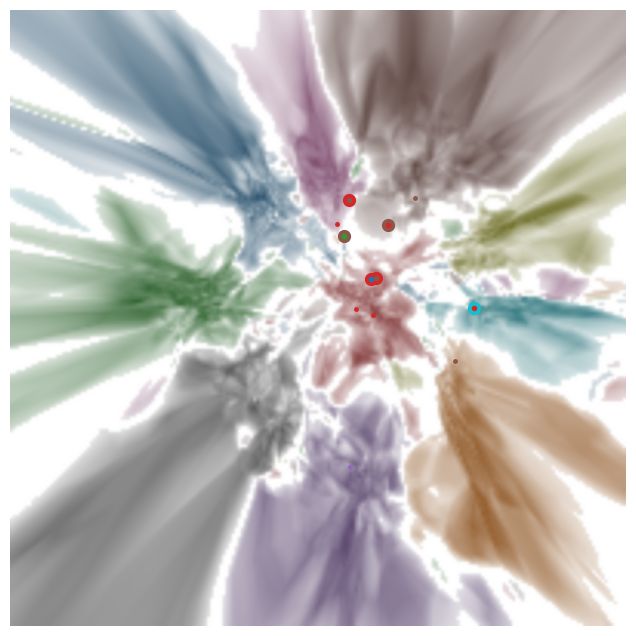

In [6]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data,I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 4930.15it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

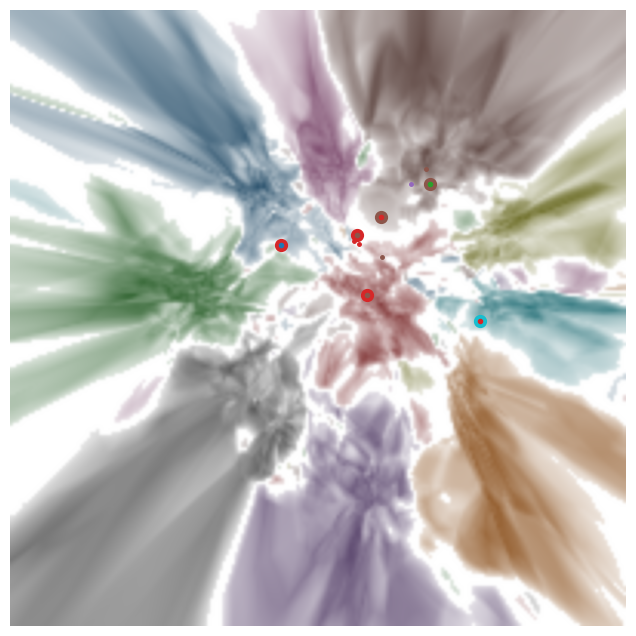

In [5]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data,R_n.detach().numpy()), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8122.26it/s]


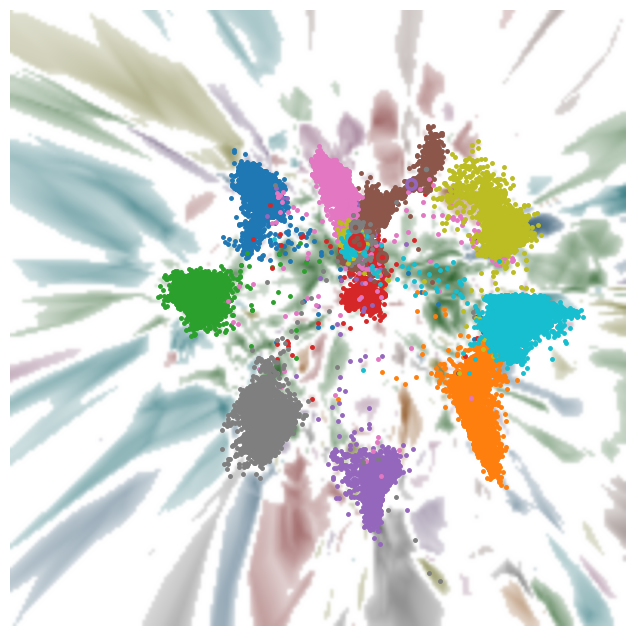

In [17]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data,R_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [5]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

R = alignment2.align_embeddings(X,Y,15000)

iteration 0, loss1 88696896.0 loss2 {tensor(0.6096, grad_fn=<RsubBackward1>)}
iteration 99, loss1 9750.2216796875 loss2 {tensor(0.7054, grad_fn=<RsubBackward1>)}
iteration 198, loss1 2526.73974609375 loss2 {tensor(0.7949, grad_fn=<RsubBackward1>)}
iteration 297, loss1 1058.8902587890625 loss2 {tensor(0.7474, grad_fn=<RsubBackward1>)}
iteration 396, loss1 578.1954956054688 loss2 {tensor(0.6790, grad_fn=<RsubBackward1>)}
iteration 495, loss1 386.1427917480469 loss2 {tensor(0.6188, grad_fn=<RsubBackward1>)}
iteration 594, loss1 293.66229248046875 loss2 {tensor(0.5675, grad_fn=<RsubBackward1>)}
iteration 693, loss1 241.48696899414062 loss2 {tensor(0.5219, grad_fn=<RsubBackward1>)}
iteration 792, loss1 208.29376220703125 loss2 {tensor(0.4810, grad_fn=<RsubBackward1>)}
iteration 891, loss1 185.22486877441406 loss2 {tensor(0.4455, grad_fn=<RsubBackward1>)}
iteration 990, loss1 168.08224487304688 loss2 {tensor(0.4148, grad_fn=<RsubBackward1>)}
iteration 1089, loss1 154.66482543945312 loss2 {te

In [181]:
X = ref_train_data
Y = tar_train_data

S = alignment3.align_embeddings(Y,X,1500)

iteration 0, loss 16394908.00601817


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 6299.80it/s]


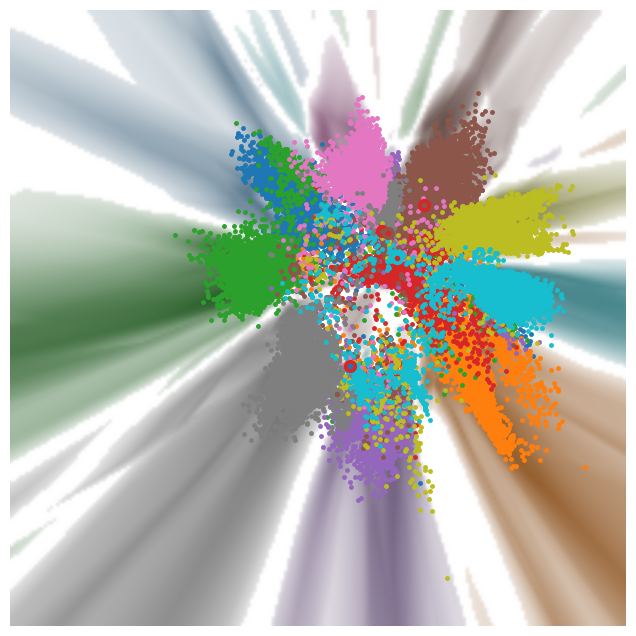

In [16]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, R.detach().numpy(),I, np.dot(ref_train_data,S.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img3.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3545.48it/s]


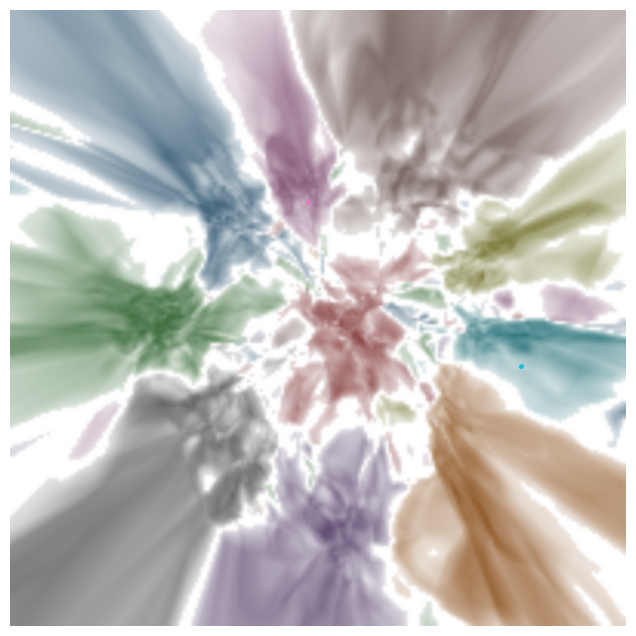

In [56]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R.detach().numpy(),I, np.dot(tar_train_data,S.detach().numpy()), projector, 200,[0,1],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8054.51it/s]


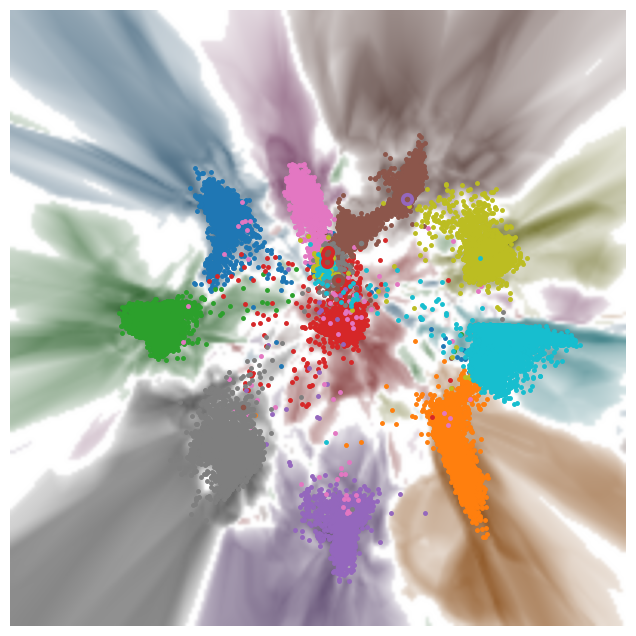

In [51]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R.detach().numpy(),I, np.dot(tar_train_data,S.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [15]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )

In [13]:
representation = ref_provider.train_representation(200)
k = 0
inidcates = predict_label_diff_indicates
for i in range(len(inidcates)):
    index = inidcates[i]
    representation[index] = new_Rep[k]
    k = k + 1

In [19]:
X = representation[np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)]
Y = tar_train_data[np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)]

R = alignment.align_embeddings(X,Y,65000)

iteration 0, loss 20187925.774051964
iteration 1000, loss 944.6314108669818
iteration 2000, loss 593.6781701573672
iteration 3000, loss 420.46400005306936
iteration 4000, loss 317.5474165681125
iteration 5000, loss 249.92746146712958
iteration 6000, loss 202.46322779902155
iteration 7000, loss 167.55183728328078
iteration 8000, loss 140.96127960359794
iteration 9000, loss 120.1529770962482
iteration 10000, loss 103.51474683550757
iteration 11000, loss 89.97525618247148
iteration 12000, loss 78.79574708080767
iteration 13000, loss 69.4508825275963
iteration 14000, loss 61.5572770754775
iteration 15000, loss 54.828881448431765
iteration 16000, loss 49.04816138686191
iteration 17000, loss 44.046919767915576
iteration 18000, loss 39.693201201128566
iteration 19000, loss 35.88214414664063
iteration 20000, loss 32.52946033269323
iteration 21000, loss 29.56670241857675
iteration 22000, loss 26.93777349233667
iteration 23000, loss 24.596314703476096
iteration 24000, loss 22.503724120240772
ite

In [31]:
len(absolute_alignment_indicates)
len(predict_label_diff_indicates)

14

In [41]:
X = representation[np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)]
Y = tar_train_data[np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)]

S = alignment.align_embeddings(Y,X,65000)

iteration 0, loss 21297217.05530683
iteration 1000, loss 1191.9002231400016
iteration 2000, loss 626.0482004815668
iteration 3000, loss 384.8390996253715
iteration 4000, loss 256.9880044948546
iteration 5000, loss 180.97369636826588
iteration 6000, loss 132.30309073974206
iteration 7000, loss 99.45397935165012
iteration 8000, loss 76.38594988668032
iteration 9000, loss 59.677247299372404
iteration 10000, loss 47.27142247866386
iteration 11000, loss 37.87285331407532
iteration 12000, loss 30.63300085266936
iteration 13000, loss 24.977797972755486
iteration 14000, loss 20.50802254305321
iteration 15000, loss 16.93941849241482
iteration 16000, loss 14.065428493256277
iteration 17000, loss 11.733281926504011
iteration 18000, loss 9.828234478940159
iteration 19000, loss 8.26293010590216
iteration 20000, loss 6.970066488816496
iteration 21000, loss 5.897241214618094
iteration 22000, loss 5.003268077087836
iteration 23000, loss 4.255503470107395
iteration 24000, loss 3.6278788620955
iteration

In [38]:
abso,_,_,_ = gen.subsetClassify(18,3,0.3,0.05)

absolute alignment indicates number: 6750 label diff indicates number: 14 confidence diff indicates number: 13 high distance number: 77


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9378.09it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

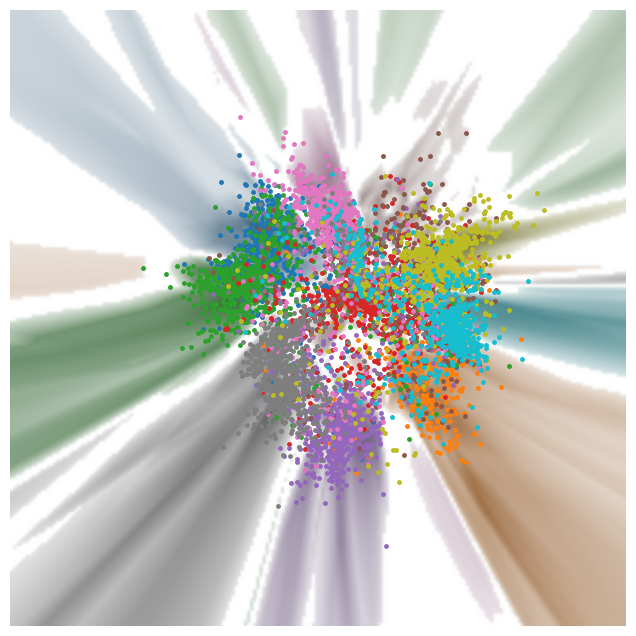

In [42]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(tar_train_data,S), projector, 200,[abso],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 8722.14it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

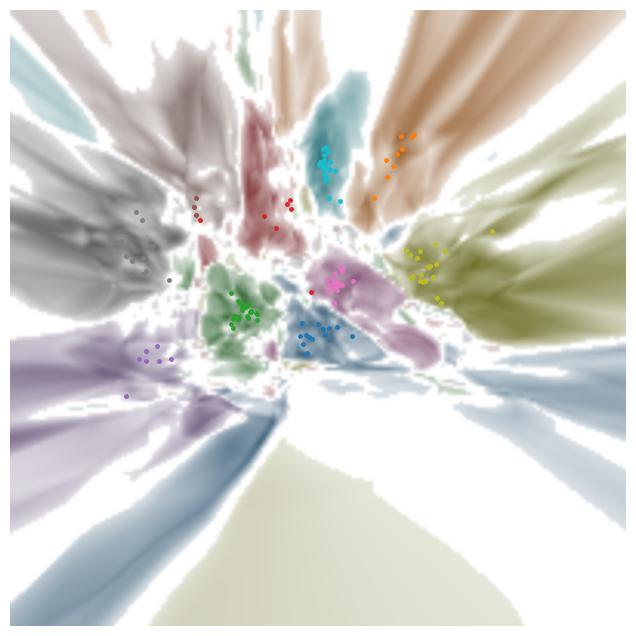

In [27]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[absolute_alignment_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 8880.40it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

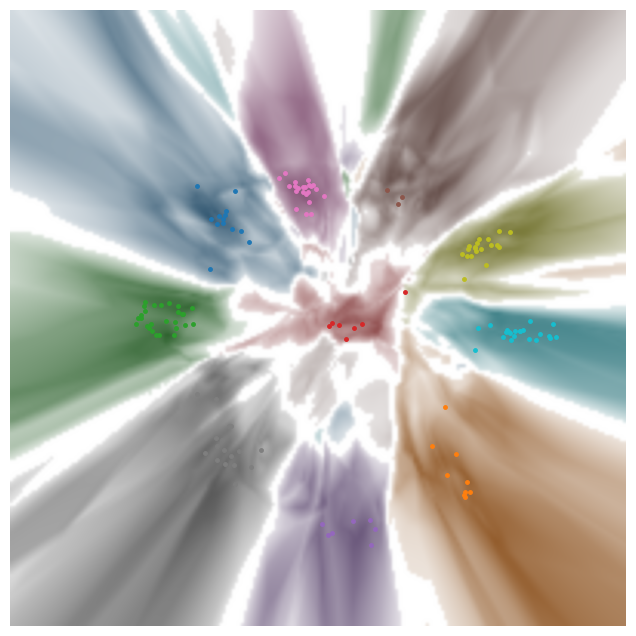

In [28]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data,I), projector, 200,[absolute_alignment_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [53]:
print('CKA between ref vs tar    absolute alignmnet subset is:',np_cka.kernel_CKA(ref_train_data[absolute_alignment_indicates],tar_train_data[absolute_alignment_indicates]))
print('CKA between ref* S vs ref absolute alignmnet subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[absolute_alignment_indicates],S),tar_train_data[absolute_alignment_indicates]))
print('CKA between tar* R vs tar absolute alignmnet subset is:',np_cka.kernel_CKA(np.dot(ref_train_data[absolute_alignment_indicates],R),ref_train_data[absolute_alignment_indicates]))

CKA between ref vs tar    absolute alignmnet subset is: 0.9337511627863128
CKA between ref* S vs ref absolute alignmnet subset is: 0.9384828433099007
CKA between tar* R vs tar absolute alignmnet subset is: 0.936695661253166


In [51]:
print('CKA between ref* S vs tar absolute alignmnet subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[absolute_alignment_indicates],S),ref_train_data[absolute_alignment_indicates]))
print('CKA between tar* R vs ref absolute alignmnet subset is:',np_cka.kernel_CKA(np.dot(ref_train_data[absolute_alignment_indicates],R),tar_train_data[absolute_alignment_indicates]))


CKA between ref* S vs tar absolute alignmnet subset is: 0.9986580425661282
CKA between tar* R vs ref absolute alignmnet subset is: 0.9987255717143393


In [49]:
print('CKA between ref vs tar diff subset is:  ',np_cka.kernel_CKA(tar_train_data[predict_label_diff_indicates],ref_train_data[predict_label_diff_indicates]))
print('CKA between ref * S vs ref diff subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[predict_label_diff_indicates],S),tar_train_data[predict_label_diff_indicates]))
print('CKA between tar * R vs ref diff subset is:',np_cka.kernel_CKA(np.dot(ref_train_data[predict_label_diff_indicates],R),ref_train_data[predict_label_diff_indicates]))
print('CKA between ref * S vs tar diff subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[predict_label_diff_indicates],S),ref_train_data[predict_label_diff_indicates]))
print('CKA between tar * R vs ref diff subset is:',np_cka.kernel_CKA(np.dot(ref_train_data[predict_label_diff_indicates],R),tar_train_data[predict_label_diff_indicates]))

CKA between ref vs tar diff subset is:   0.81107539820274
CKA between ref * S vs ref diff subset is: 0.9793333528272284
CKA between tar * R vs ref diff subset is: 0.9568967260339654
CKA between ref * S vs tar diff subset is: 0.7926897522378636
CKA between tar * R vs ref diff subset is: 0.8180348739210448


In [45]:
print('CKA between adjusted * S vs tar diff subset is:',np_cka.kernel_CKA(np.dot(tar_train_data[absolute_alignment_indicates],S),ref_train_data[absolute_alignment_indicates]))
print('CKA between tar* R vs adjuested diff subset is:',np_cka.kernel_CKA(np.dot(ref_train_data[absolute_alignment_indicates],R),tar_train_data[absolute_alignment_indicates]))

CKA between adjusted * S vs tar diff subset is: 0.9986580425661282
CKA between tar* R vs adjuested diff subset is: 0.9987255717143393


Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3276.80it/s]


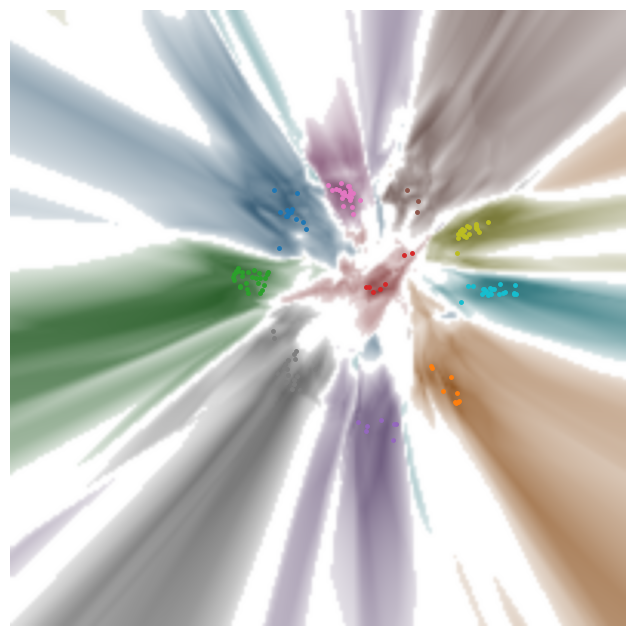

In [34]:
##### reference dropout target without dropout 

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, S,I, np.dot(representation,R), projector, 200,[absolute_alignment_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [66]:
print('CKA between adjusted vs ref diff subset is:',np_cka.kernel_CKA(np.dot(ref_train_data,S)[[predict_label_diff_indicates]],tar_train_data[predict_label_diff_indicates]))

CKA between adjusted vs ref diff subset is: 0.8110179471254885


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [68]:
print('CKA between adjusted vs ref diff subset is:',np_cka.kernel_CKA(np.dot(representation,S)[[absolute_alignment_indicates]],tar_train_data[absolute_alignment_indicates]))

CKA between adjusted vs ref diff subset is: 0.9001868545294588


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [67]:
print('CKA between adjusted vs ref diff subset is:',np_cka.kernel_CKA(np.dot(representation,S)[[predict_label_diff_indicates]],tar_train_data[predict_label_diff_indicates]))

CKA between adjusted vs ref diff subset is: 0.9573383448259455


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


147

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8127.61it/s]


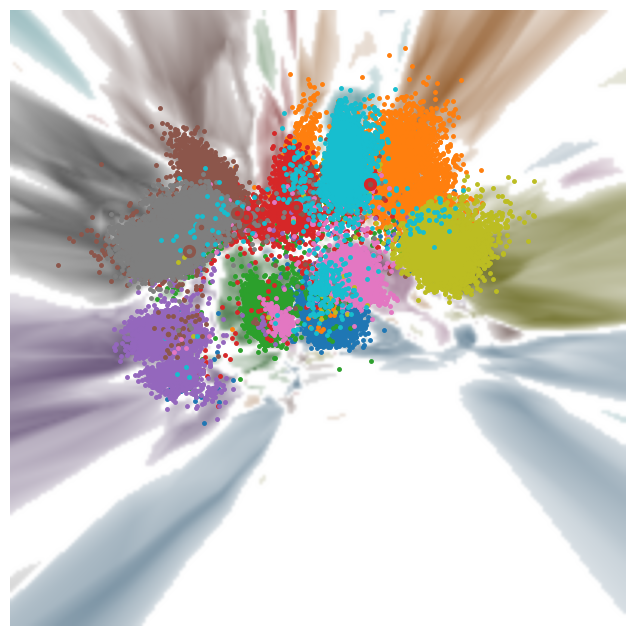

In [69]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(tar_train_data,S), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))